# Análisis de precios del mercado diario de la electricidad

En este notebook se analizan los precios del mercado diario de la electricidad en España.

## Obtención de los datos

Los datos de precios del mercado de la electricidad se han obtenido del portal de datos abiertos del Operador del Mercado Ibérico de Energía (OMIE) en la ruta [Home → Market Results → File access → Day-ahead market hourly prices in Spain](https://www.omie.es/en/file-access-list?parents=/Day-ahead%20Market/1.%20Prices&dir=%20Day-ahead%20market%20hourly%20prices%20in%20Spain&realdir=marginalpdbc).

Dado que el los datos más antiguos están publicados en la página de OMIE como un zip comprimido con todos los ficheros dentro, y los ficheros más recientes se encuentran por separado, se recogen unos y otros por separado para juntarlos posteriormente.

In [2]:
import pandas as pd
import requests
from io import BytesIO
from zipfile import ZipFile
from datetime import datetime, timedelta
from tqdm.notebook import tqdm

In [ ]:
def descargar_precios_omie(ano):
    url = f"https://www.omie.es/es/file-download?parents%5B0%5D=marginalpdbc&filename=marginalpdbc_{ano}.zip"
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Error al descargar el archivo de {ano}")
        return None

    zipfile = ZipFile(BytesIO(response.content))
    csv_files = [f for f in zipfile.namelist() if f.endswith('.1')]

    dfs = []
    for csv_file in csv_files:
        df = pd.read_csv(zipfile.open(csv_file), sep=';', encoding='latin1', decimal='.', skiprows=1, skipfooter=1, header=None, engine='python')
            
        df['fecha_base'] = pd.to_datetime(df[0].astype(str) + '-' + 
                                        df[1].astype(str).str.zfill(2) + '-' + 
                                        df[2].astype(str).str.zfill(2))

        df['fecha'] = df['fecha_base'] + pd.to_timedelta(df[3] - 1, unit='h')

        df = df[['fecha', 4]]
        df.rename(columns={4 : 'precio_MD'}, inplace=True)

        df.drop_duplicates(subset=['fecha'], inplace=True)
        dfs.append(df)

    df = pd.concat(dfs)

    return df

datos = []
for ano in [2020, 2021, 2022]: # Disponibilidad de datos desde 2018
    df = descargar_precios_omie(ano)
    if df is not None:
        datos.append(df)

df_precios = pd.concat(datos).reset_index(drop=True)

df_precios.to_csv('precio_diario_espana_2020_2022.csv', index=False)
print("Archivo guardado como 'precio_diario_espana_2020_2022.csv'")

df_precios

Archivo guardado como 'precio_diario_espana_2020_2022.csv'


,fecha,precio_MD
0,2020-01-01 00:00:00,41.88
1,2020-01-01 01:00:00,38.60
2,2020-01-01 02:00:00,36.55
3,2020-01-01 03:00:00,32.32
4,2020-01-01 04:00:00,30.85
...,...,...
26275,2022-12-31 19:00:00,11.01
26276,2022-12-31 20:00:00,7.60
26277,2022-12-31 21:00:00,3.69
26278,2022-12-31 22:00:00,1.88


In [ ]:
# Generar lista de fechas desde el 1 de enero de 2023 hasta hoy
fecha_inicio = datetime(2023, 1, 1)
fecha_fin = datetime.today()

archivos_2023_hoy = []

for i in range((fecha_fin - fecha_inicio).days + 1):
    fecha = (fecha_inicio + timedelta(days=i)).strftime('%Y%m%d')
    url = f"https://www.omie.es/es/file-download?parents%5B0%5D=marginalpdbc&filename=marginalpdbc_{fecha}.1"
    archivos_2023_hoy.append(url)

dfs = []
for archivo in tqdm(archivos_2023_hoy, desc="Descargando y procesando archivos"):
    try:
        response = requests.get(archivo)
        if response.status_code != 200:
            continue
        df = pd.read_csv(
            BytesIO(response.content),
            sep=';',
            encoding='latin1',
            decimal='.',
            skiprows=1,
            skipfooter=1,
            header=None,
            engine='python'
        )
        df['fecha_base'] = pd.to_datetime(df[0].astype(str) + '-' +
                                          df[1].astype(str).str.zfill(2) + '-' +
                                          df[2].astype(str).str.zfill(2))
        df['fecha'] = df['fecha_base'] + pd.to_timedelta(df[3] - 1, unit='h')
        df = df[['fecha', 4]]
        df = df.rename(columns={4: 'precio_MD'})
        dfs.append(df)
    except Exception as e:
        print(f"Error procesando {archivo}: {e}")

df_precios_sueltos = pd.concat(dfs).reset_index(drop=True)
df_precios_sueltos.to_csv('precios_md_desde_2023.csv', index=False)
print("Archivo guardado como 'precios_md_desde_2023.csv'")

df_precios_sueltos

,fecha,precio_MD
0,2022-01-01 00:00:00,114.90
1,2022-01-01 01:00:00,113.87
2,2022-01-01 02:00:00,97.80
3,2022-01-01 03:00:00,97.80
4,2022-01-01 04:00:00,95.74
...,...,...
26444,2025-01-07 20:00:00,159.66
26445,2025-01-07 21:00:00,129.78
26446,2025-01-07 22:00:00,130.14
26447,2025-01-07 23:00:00,120.00


In [ ]:
df = pd.concat([df_precios, df_precios_sueltos]).reset_index(drop=True)
df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values('fecha')

df.to_csv('precios_md_OMIE.csv', index=False)
df

,fecha,precio_MD
0,2020-01-01 00:00:00,41.88
1,2020-01-01 01:00:00,38.60
2,2020-01-01 02:00:00,36.55
3,2020-01-01 03:00:00,32.32
4,2020-01-01 04:00:00,30.85
...,...,...
43988,2025-01-07 20:00:00,159.66
43989,2025-01-07 21:00:00,129.78
43990,2025-01-07 22:00:00,130.14
43991,2025-01-07 23:00:00,120.00


## Filtrado

In [ ]:
df = df[df['fecha'] < pd.Timestamp('2025-01-01')]
df

,fecha,precio_MD
0,2020-01-01 00:00:00,41.88
1,2020-01-01 01:00:00,38.60
2,2020-01-01 02:00:00,36.55
3,2020-01-01 03:00:00,32.32
4,2020-01-01 04:00:00,30.85
...,...,...
43819,2024-12-31 19:00:00,156.10
43820,2024-12-31 20:00:00,150.85
43821,2024-12-31 21:00:00,144.40
43822,2024-12-31 22:00:00,139.37


## Visualizaciones

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

figsize = (14, 6)

title_fontsize = 16
xlabel_fontsize = 13
ylabel_fontsize = 13
xticks_fontsize = 14
yticks_fontsize = 14

xticks_rotation = 25

title_fontweight = 'bold'
xlabel_fontweight = 'bold'
ylabel_fontweight = 'bold'

legend_fontsize = 15

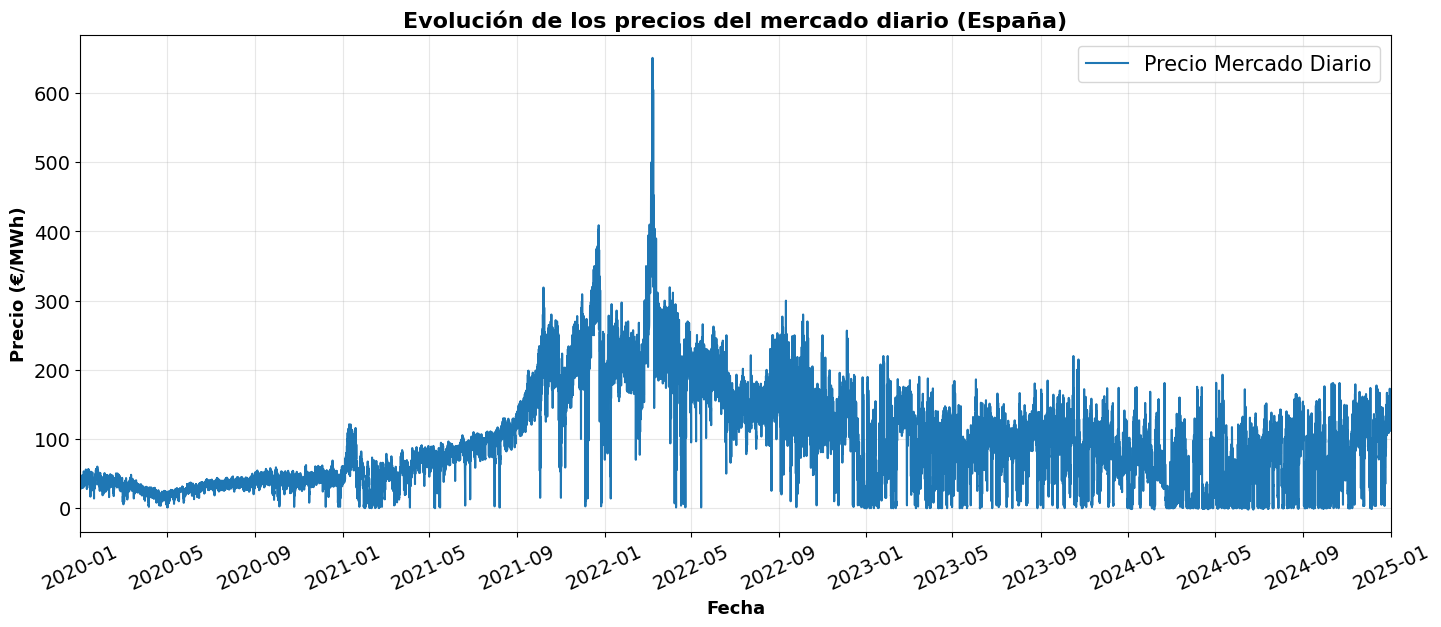

In [71]:
plt.figure(figsize=figsize)
plt.plot(df['fecha'], df['precio_MD'], label='Precio Mercado Diario')

plt.title('Evolución de los precios del mercado diario (España)', fontsize=title_fontsize, fontweight=title_fontweight)
plt.xlabel('Fecha', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Precio (€/MWh)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(fontsize=legend_fontsize)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 5, 9)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df['fecha'].min(), pd.Timestamp('2025-01-01'))

plt.xticks(rotation=25, fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)
plt.show()

Como podemos ver, en esta gráfica hay mucho ruido, debido principalmente a que los precios varían mucho en función de la hora del día y en función del día de la semana, como se comprueba ahora. Aun así, ya se empieza a observar la subida de precios de finales del año 2021, y el aumento de volatilidad que llega hasta nuestros días.

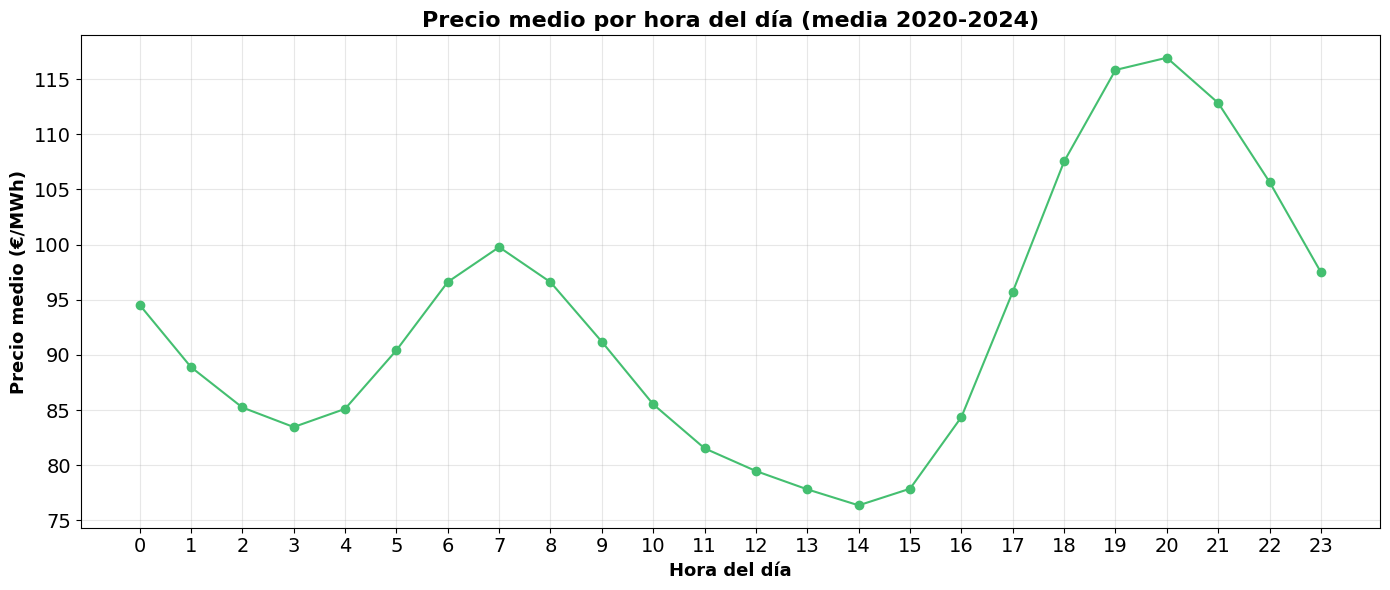

In [ ]:
# Extraer la hora de cada registro
df['hora'] = df['fecha'].dt.hour

# Calcular la media de precio por hora del día (promedio de todos los años)
media_por_hora = df.groupby('hora', observed=True)['precio_MD'].mean()

plt.figure(figsize=figsize)

plt.plot(media_por_hora.index, media_por_hora.values, marker='o', color=plt.cm.viridis(0.7))
plt.xlabel('Hora del día', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Precio medio (€/MWh)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
plt.title('Precio medio por hora del día (media 2020-2024)', fontsize=title_fontsize, fontweight=title_fontweight)

plt.xticks(range(24), fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Como cabría esperar, el precio medio de todos los años agrupado por hora destaca el inicio de la actividad laboral y escolar en torno a las siete de la mañana, y el mayor consumo en hogares en entre las ocho y las nueve de la noche, coincidente también con el descenso de producción de la energía fotovoltaica.

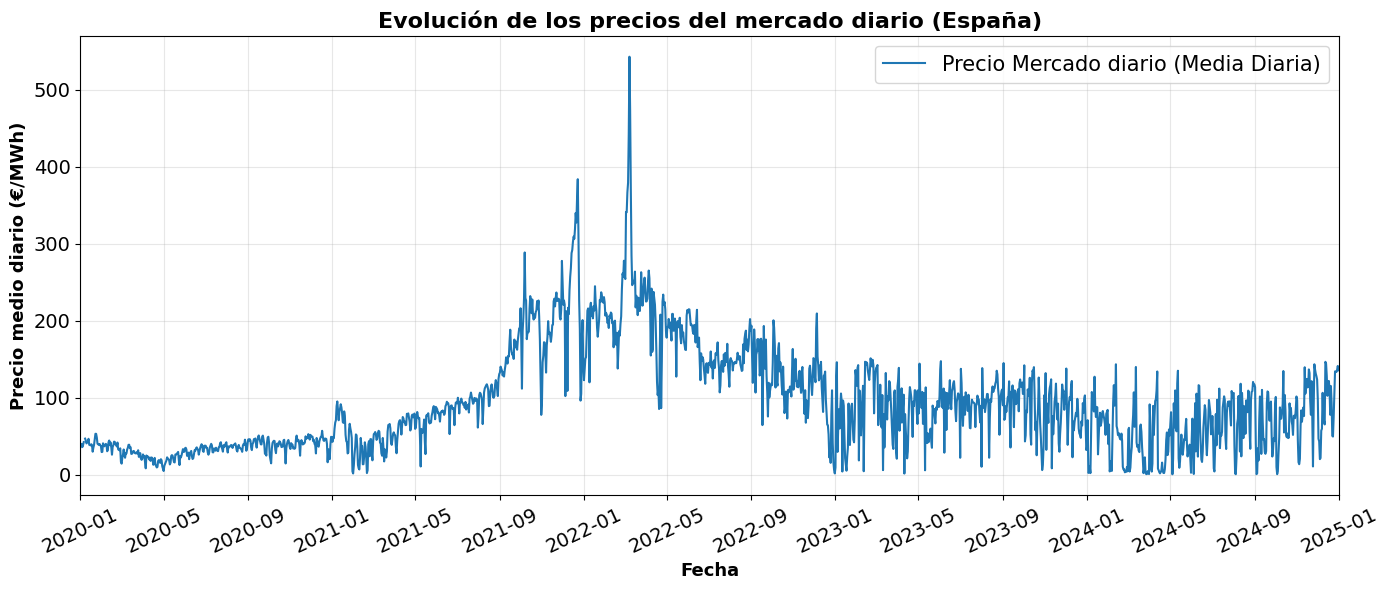

In [82]:
# Calcular el precio medio diario
df_diario = df.resample('D', on='fecha').mean(numeric_only=True).reset_index()

plt.figure(figsize=figsize)

plt.plot(df_diario['fecha'], df_diario['precio_MD'], label='Precio Mercado diario (Media Diaria)')
plt.title('Evolución de los precios del mercado diario (España)', fontsize=title_fontsize, fontweight=title_fontweight)
plt.xlabel('Fecha', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Precio medio diario (€/MWh)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 5, 9)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df['fecha'].min(), pd.Timestamp('2025-01-01'))

plt.xticks(rotation=xticks_rotation, fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.legend(fontsize=legend_fontsize)
plt.show()

Al hacer la media de precios del día reducimos drásticamente la volatilidad, pero seguimos teniendo muchos picos, probablemente debidos a las diferencias que existen entre los precios de lunes a viernes, y los precios de sábado y domingo.

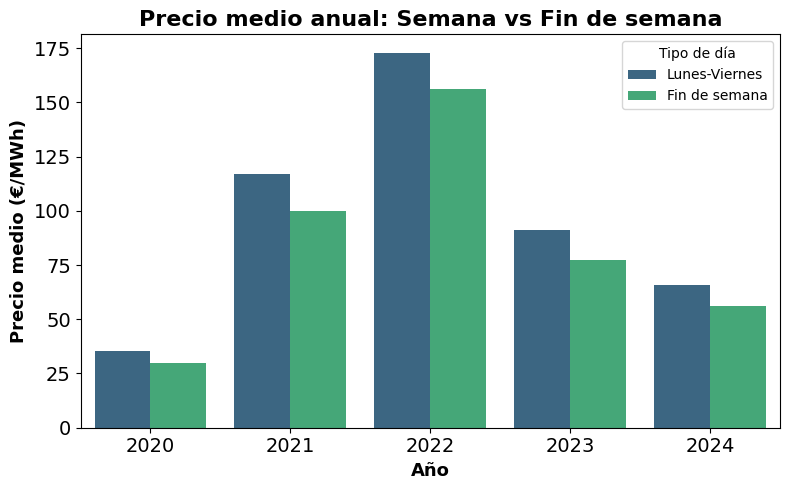

In [81]:
# Crear columna para distinguir entre semana y fin de semana 
df['tipo_dia'] = df['fecha'].dt.dayofweek.apply(lambda x: 'Lunes-Viernes' if x < 5 else 'Fin de semana')
orden_tipo_dia = ['Lunes-Viernes', 'Fin de semana']

df['tipo_dia'] = pd.Categorical(df['tipo_dia'], categories=orden_tipo_dia, ordered=True)
df['anio'] = df['fecha'].dt.year

# Calcular la media por tipo de día y año
media_por_tipo_anio = df.groupby(['anio', 'tipo_dia'], observed=True)['precio_MD'].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.barplot(
    data=media_por_tipo_anio,
    x='anio',
    y='precio_MD',
    hue='tipo_dia',
    hue_order=orden_tipo_dia,
    palette='viridis'
)

plt.xlabel('Año', fontsize=xlabel_fontsize, fontweight=xlabel_fontweight)
plt.ylabel('Precio medio (€/MWh)', fontsize=ylabel_fontsize, fontweight=ylabel_fontweight)
plt.title('Precio medio anual: Semana vs Fin de semana', fontsize=title_fontsize, fontweight=title_fontweight)

plt.xticks(fontsize=xticks_fontsize)
plt.yticks(fontsize=yticks_fontsize)
plt.legend(title='Tipo de día')
plt.tight_layout()
plt.show()

Podemos comprobar cómo el fin de semana suele tener precios mucho más bajos que los días de entre semana para todos los años estudiados.

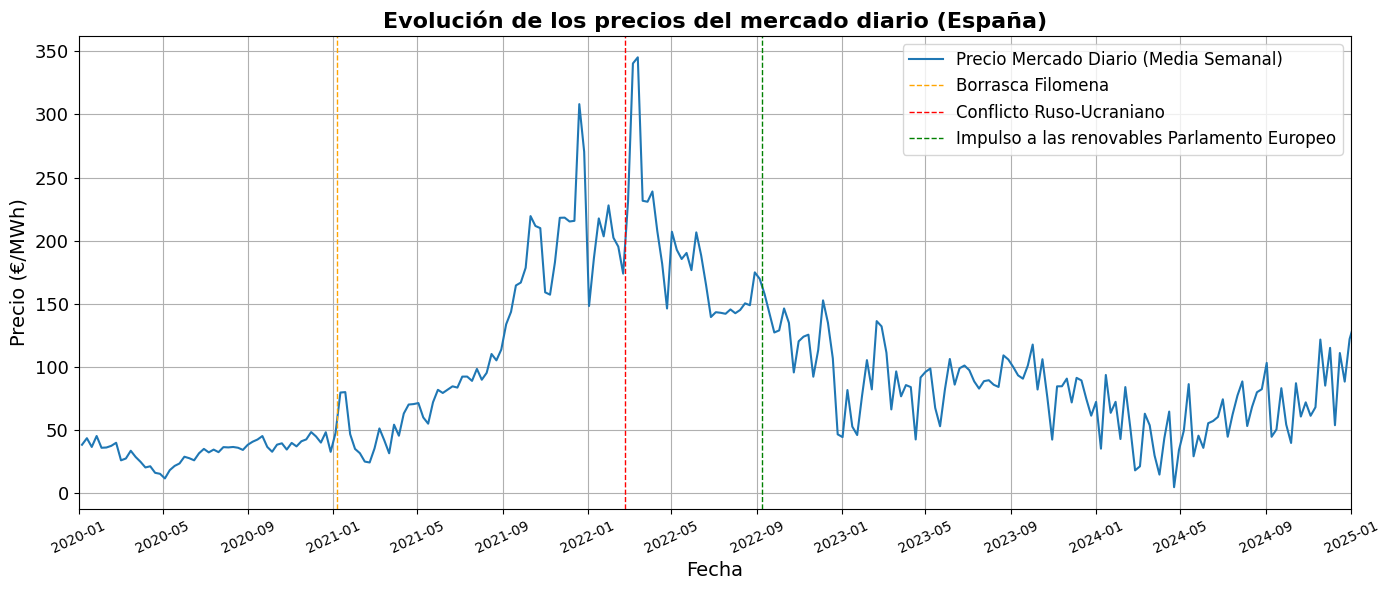

In [83]:
df_precio_medio_semanal = df.resample('W-MON', on='fecha').mean(numeric_only=True).reset_index()

plt.figure(figsize=(14, 6))
plt.plot(df_precio_medio_semanal['fecha'], df_precio_medio_semanal['precio_MD'], label='Precio Mercado Diario (Media Semanal)')

plt.axvline(pd.Timestamp('2021-01-06'), color='orange', linestyle='--', linewidth=1, label='Borrasca Filomena')
# plt.axvline(pd.Timestamp('2021-10-07'), color='green', linestyle='--', linewidth=1, label='Kremlin propone exportar más gas a Europa')
# plt.axvline(pd.Timestamp('2021-11-01'), color='red', linestyle='--', linewidth=1, label='Cierre del Gasoducto Magreb Europa (GME)')
# plt.axvline(pd.Timestamp('2021-12-22'), color='green', linestyle='--', linewidth=1, label='Desembarco asiático de GNL')
plt.axvline(pd.Timestamp('2022-02-24'), color='red', linestyle='--', linewidth=1, label='Conflicto Ruso-Ucraniano')
plt.axvline(pd.Timestamp('2022-09-09'), color='green', linestyle='--', linewidth=1, label='Impulso a las renovables Parlamento Europeo')
# plt.axvline(pd.Timestamp('2022-12-19'), color='green', linestyle='--', linewidth=1, label='Medidas de solidaridad del Consejo Europeo')

plt.title('Evolución de los precios del mercado diario (España)', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Precio (€/MWh)', fontsize=14)
plt.grid(True)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 5, 9)))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().set_xlim(df['fecha'].min(), pd.Timestamp('2025-01-01'))

plt.xticks(rotation=25)
plt.yticks(fontsize=13)
plt.tight_layout()
plt.legend(fontsize=12, frameon=True)
plt.show()

Podemos ver cómo ahora la gráfica presenta mucho menos ruido. Además, se han introducido factores climáticos y geopolíticos relevantes para el análisis que parecen haber influido en el precio del mercado diario de la energía en España.